In [ ]:
!pip install numpy pandas matplotlib ucimlrepo scikit-learn tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
digits = fetch_ucirepo(id=80)
X = digits.data.features
y = digits.data.targets


In [ ]:
if hasattr(X, 'values'):
    X = X.values.astype(np.float32)
else:
    X = X.astype(np.float32)

if hasattr(y, 'values'):
    y = y.values.ravel()
else:
    y = y.ravel()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Форма данных после стандартизации: {X_scaled.shape}")
print(f"Диапазон целевой переменной: {np.min(y)}-{np.max(y)}")
print(f"Уникальные классы: {np.unique(y_encoded)}")


Форма данных после стандартизации: (5620, 64)
Диапазон целевой переменной: 0-9
Уникальные классы: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
def create_autoencoder(input_dim, latent_dim):
    input_layer = layers.Input(shape=(input_dim,))

    encoder = layers.Dense(256, activation='relu')(input_layer)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Dropout(0.1)(encoder)

    encoder = layers.Dense(128, activation='relu')(encoder)
    encoder = layers.BatchNormalization()(encoder)

    encoder = layers.Dense(64, activation='relu')(encoder)
    latent = layers.Dense(latent_dim, activation='relu')(encoder)

    decoder = layers.Dense(64, activation='relu')(latent)
    decoder = layers.BatchNormalization()(decoder)

    decoder = layers.Dense(128, activation='relu')(decoder)
    decoder = layers.BatchNormalization()(decoder)

    decoder = layers.Dense(256, activation='relu')(decoder)
    decoder = layers.Dropout(0.1)(decoder)

    output_layer = layers.Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = models.Model(input_layer, output_layer)
    encoder_model = models.Model(input_layer, latent)

    optimizer = Adam(learning_rate=0.001)

    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder, encoder_model

In [ ]:
def plot_projection(data, y, title, dimensions=2):
    if dimensions == 2:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(data[:, 0], data[:, 1], c=y, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter)
        plt.title(title)
        plt.xlabel('Первая компонента')
        plt.ylabel('Вторая компонента')
    else:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y, cmap='viridis', alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel('Первая компонента')
        ax.set_ylabel('Вторая компонента')
        ax.set_zlabel('Третья компонента')
        fig.colorbar(scatter)

    plt.show()

Автоэнкодер (2 компоненты) - train loss: 0.7440, val loss: 0.6944


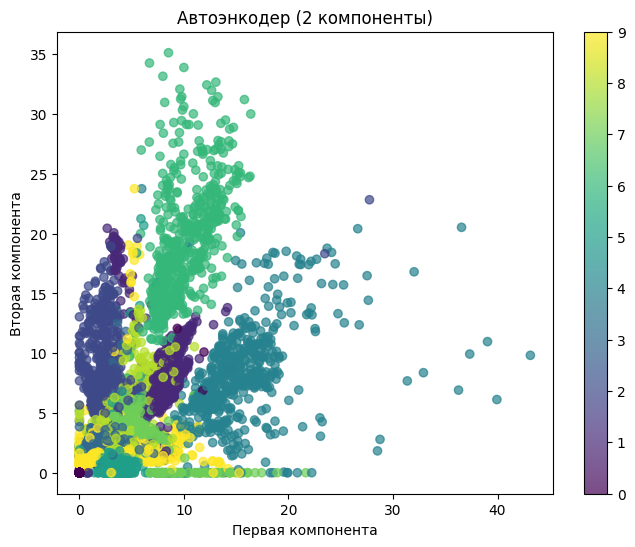

In [ ]:
autoencoder_2, encoder_2 = create_autoencoder(X_train.shape[1], 2)
history_2 = autoencoder_2.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_test, X_test), verbose=0)
train_loss_2 = history_2.history['loss'][-1]
val_loss_2 = history_2.history['val_loss'][-1]
print(f"Автоэнкодер (2 компоненты) - train loss: {train_loss_2:.4f}, val loss: {val_loss_2:.4f}")
encoded_2d = encoder_2.predict(X_scaled, verbose=0)
plot_projection(encoded_2d, y_encoded, 'Автоэнкодер (2 компоненты)', 2)

Автоэнкодер (3 компоненты) - train loss: 0.7094, val loss: 0.6630


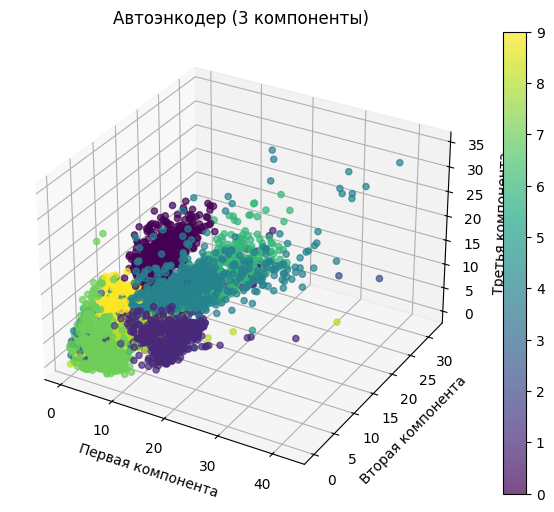

In [ ]:
autoencoder_3, encoder_3 = create_autoencoder(X_train.shape[1], 3)
history_3 = autoencoder_3.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_test, X_test), verbose=0)
train_loss_3 = history_3.history['loss'][-1]
val_loss_3 = history_3.history['val_loss'][-1]
print(f"Автоэнкодер (3 компоненты) - train loss: {train_loss_3:.4f}, val loss: {val_loss_3:.4f}")
encoded_3d = encoder_3.predict(X_scaled, verbose=0)
plot_projection(encoded_3d, y_encoded, 'Автоэнкодер (3 компоненты)', 3)

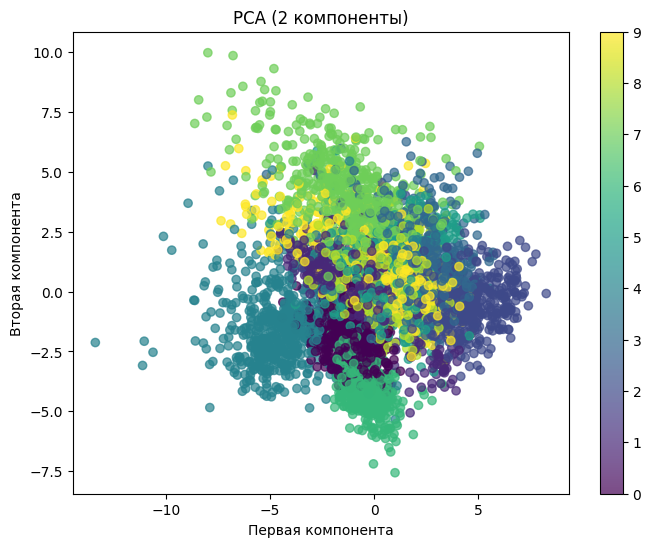

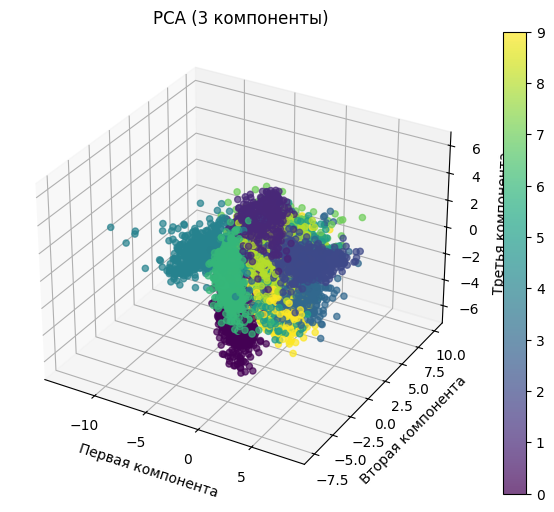

In [ ]:
X_pca_2 = PCA(n_components=2).fit_transform(X_scaled)
X_pca_3 = PCA(n_components=3).fit_transform(X_scaled)
plot_projection(X_pca_2, y_encoded, 'PCA (2 компоненты)', 2)
plot_projection(X_pca_3, y_encoded, 'PCA (3 компоненты)', 3)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


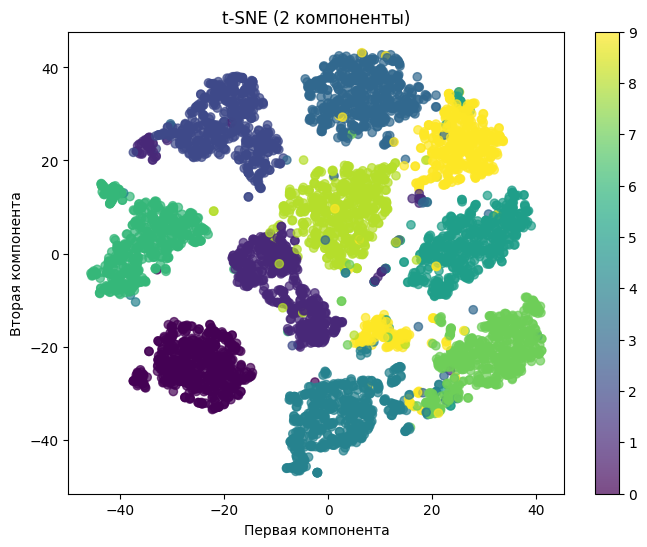

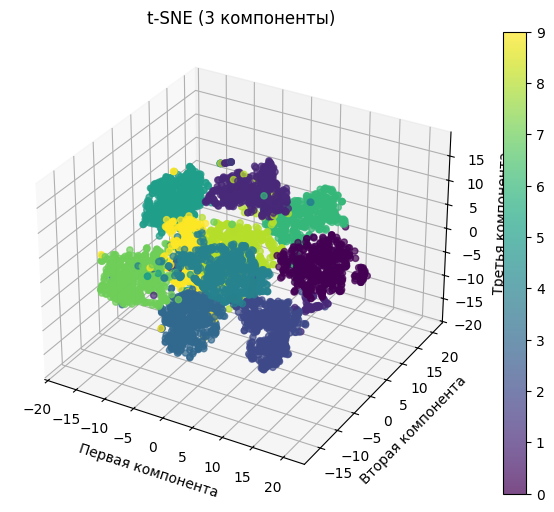

In [ ]:
X_tsne_2 = TSNE(n_components=2,
    random_state=42,
    perplexity=30,
    n_iter=500,
    learning_rate=200,
    init='random').fit_transform(X_scaled)
X_tsne_3 = TSNE(n_components=3,
    random_state=42,
    perplexity=30,
    n_iter=500,
    learning_rate=200,
    init='random').fit_transform(X_scaled)
plot_projection(X_tsne_2, y_encoded, 't-SNE (2 компоненты)', 2)
plot_projection(X_tsne_3, y_encoded, 't-SNE (3 компоненты)', 3)